In [1]:
%cd "F:\University\Master's Thesis\Datasets\rnd"

F:\University\Master's Thesis\Datasets\rnd


In [17]:
%pip install pytorch-lightning
%pip install lightning


Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

# Load Bitbrains dataset into a DataFrame
file_path = 'bitbrains_structured_data.csv'
df = pd.read_csv(file_path)
df.head(5)

,VM,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],time_idx,Memory usage [%]
0,VM001,1372629804,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,1.466667,1,12.588394
1,VM001,1372630104,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,1.000000,2,5.579711
2,VM001,1372630404,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,1.066667,3,2.245485
3,VM001,1372630704,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,1.000000,4,0.952620
4,VM001,1372631004,2,5851.9989,19.506663,0.333333,8218624.0,1.677720e+05,0.000000,0.200000,0.133333,1.000000,5,2.041364


In [6]:
from pytorch_forecasting.data import MultiNormalizer

max_prediction_length = 64
max_encoder_length = 256
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Memory usage [%]",
    group_ids=["VM"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["VM"],
    static_reals=["CPU cores", "Memory capacity provisioned [KB]"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Memory usage [%]",
        "Memory usage [KB]"
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [7]:
training.get_parameters()

{'time_idx': 'time_idx',
 'target': 'Memory usage [%]',
 'group_ids': ['VM'],
 'weight': None,
 'max_encoder_length': 256,
 'min_encoder_length': 128,
 'min_prediction_idx': 1,
 'min_prediction_length': 1,
 'max_prediction_length': 64,
 'static_categoricals': ['VM'],
 'static_reals': ['CPU cores',
  'Memory capacity provisioned [KB]',
  'encoder_length',
  'Memory usage [%]_center',
  'Memory usage [%]_scale'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['time_idx', 'relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['Memory usage [%]', 'Memory usage [KB]'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__gro

In [8]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(1.4739)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 12.1k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.09332543007969905
Restoring states from the checkpoint path at F:\University\Master's Thesis\Datasets\rnd\.lr_find_5088cc12-6a58-48bd-ada6-99707b4f7770.ckpt
Restored all states from the checkpoint at F:\University\Master's Thesis\Datasets\rnd\.lr_find_5088cc12-6a58-48bd-ada6-99707b4f7770.ckpt


suggested learning rate: 0.09332543007969905


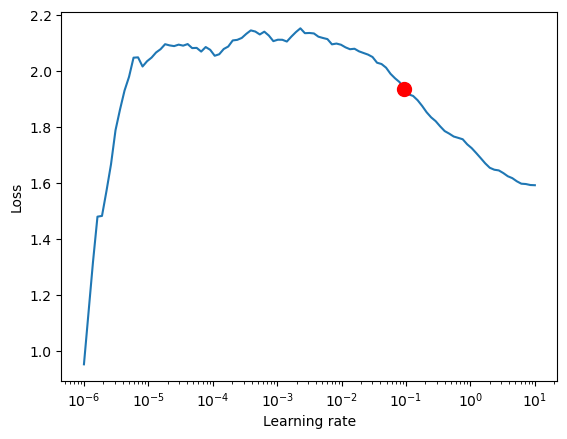

In [9]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [22]:
import tensorflow as tf
import tensorboard as tb

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 255.0k


In [23]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 26.0 K
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

In [24]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [25]:
# Saving the model to disk
import pickle

# save study results - also we can resume tuning at a later point in time
with open("tft_bitbrains_v1.pkl", "wb") as fout:
    pickle.dump(best_tft, fout)

In [26]:
import pickle

with open("tft_bitbrains_v1.pkl",'rb') as f:
    best_tft=pickle.load(f)
    

In [27]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(1.0760)

In [28]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

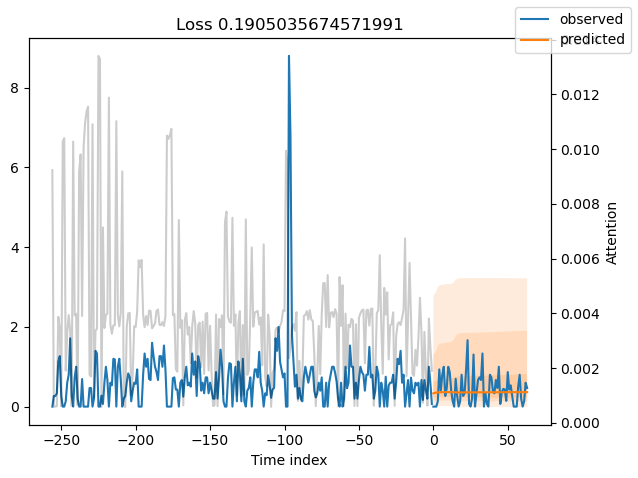

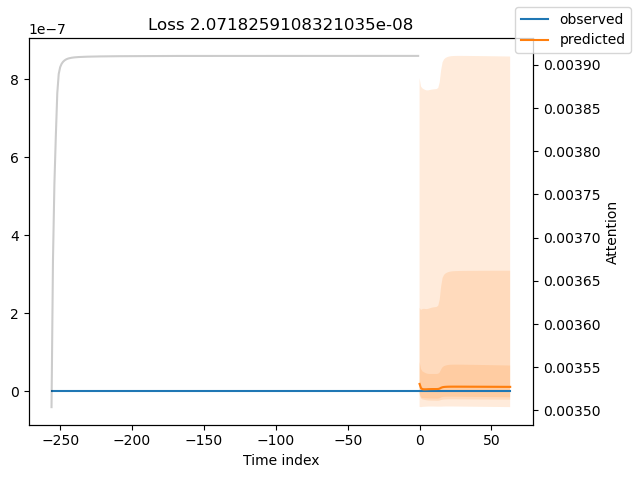

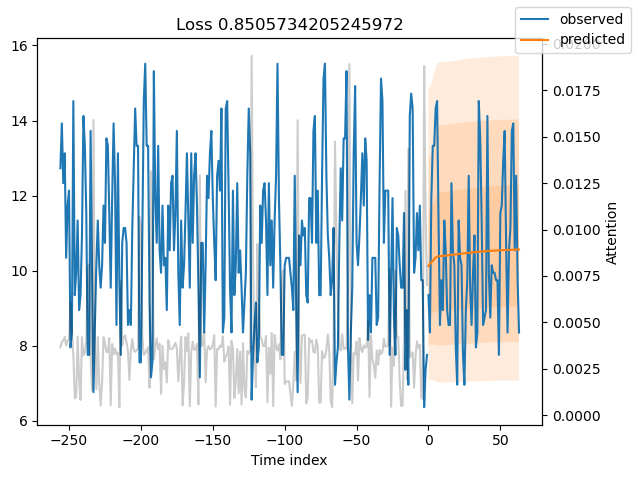

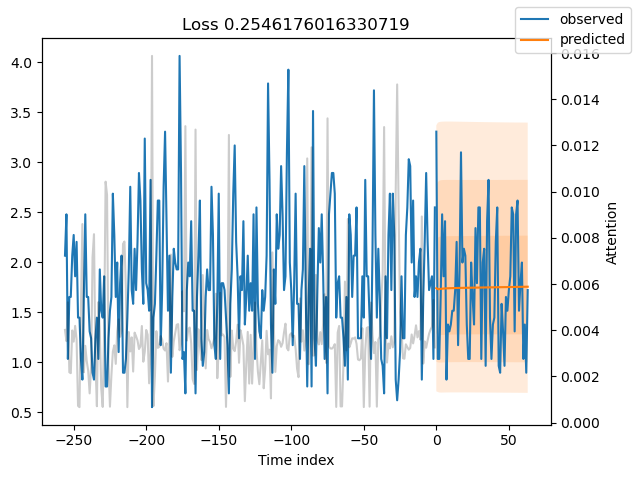

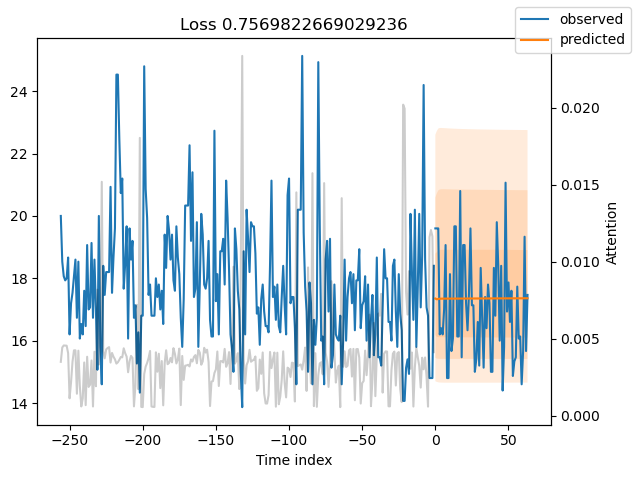

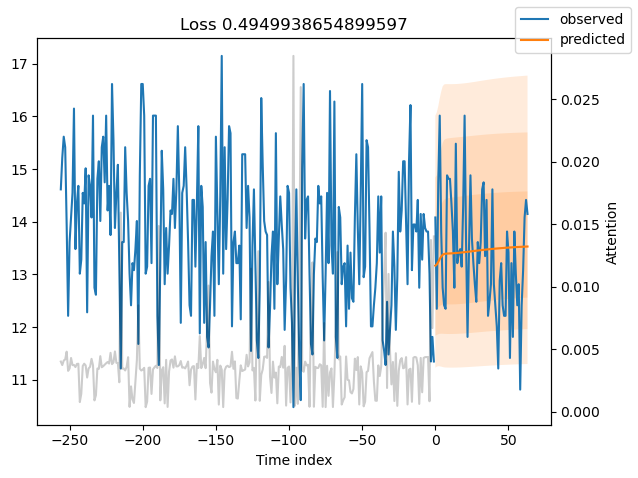

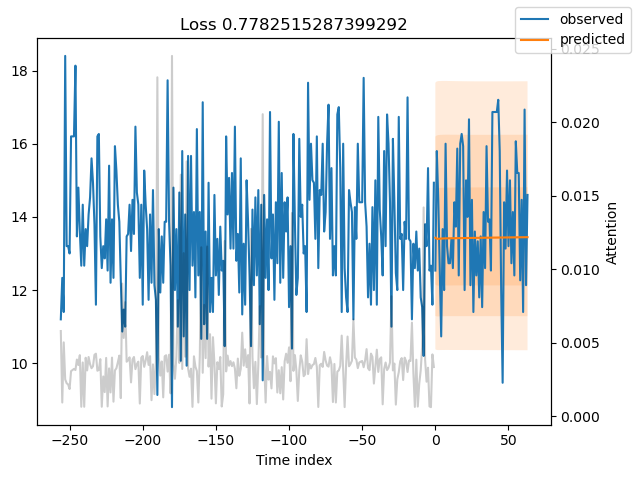

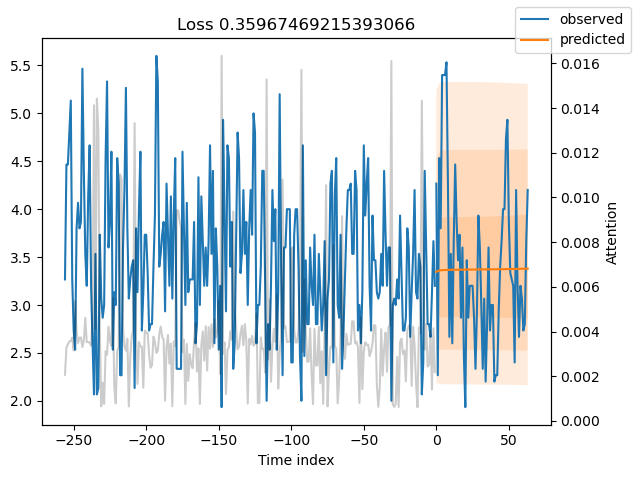

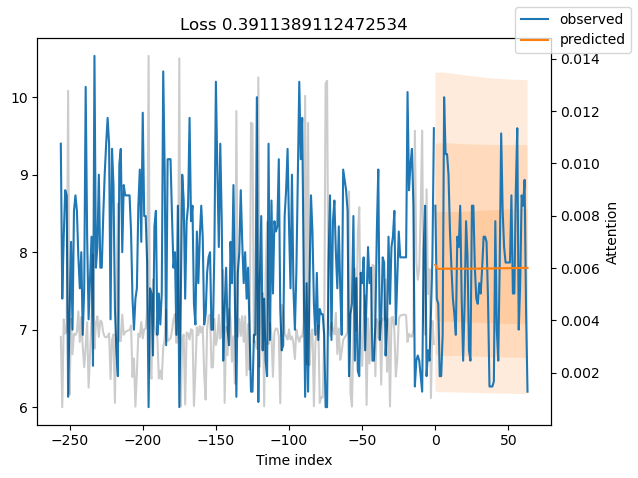

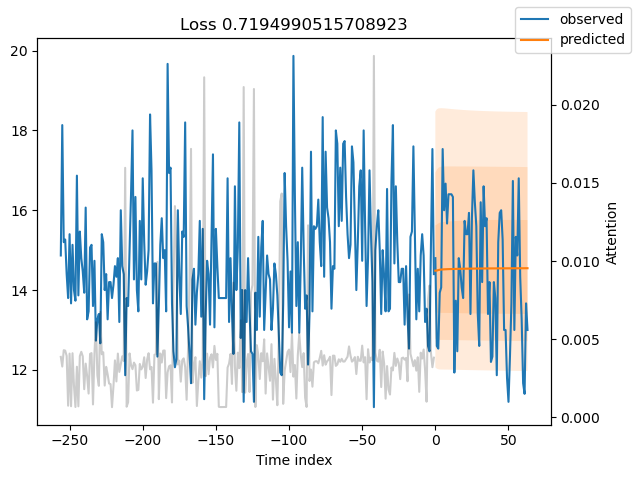

In [29]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'CPU cores': <Figure size 1000x500 with 2 Axes>,
 'Memory capacity provisioned [KB]': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Memory usage [%]_center': <Figure size 1000x500 with 2 Axes>,
 'Memory usage [%]_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Memory usage [%]': <Figure size 1000x500 with 2 Axes>,
 'Memory usage [KB]': <Figure size 1000x500 with 2 Axes>,
 'VM': <Figure size 1000x500 with 2 Axes>}

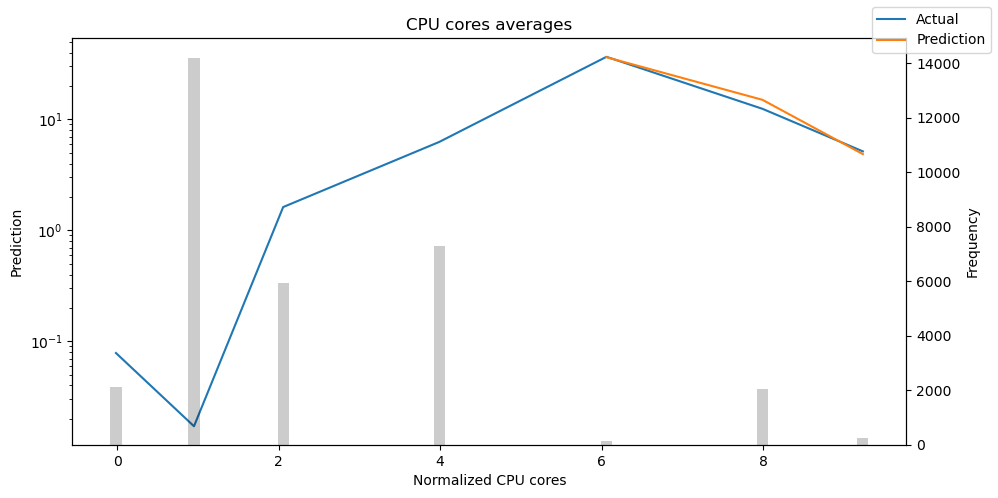

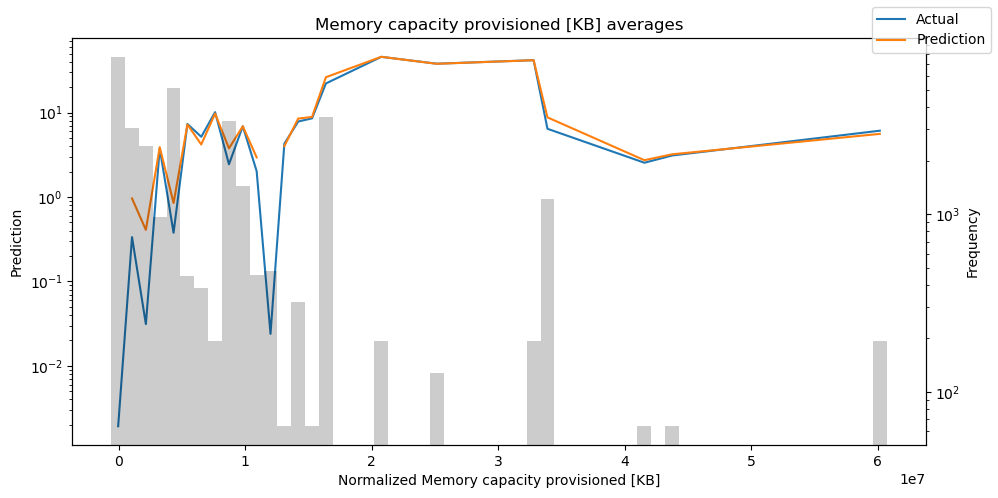

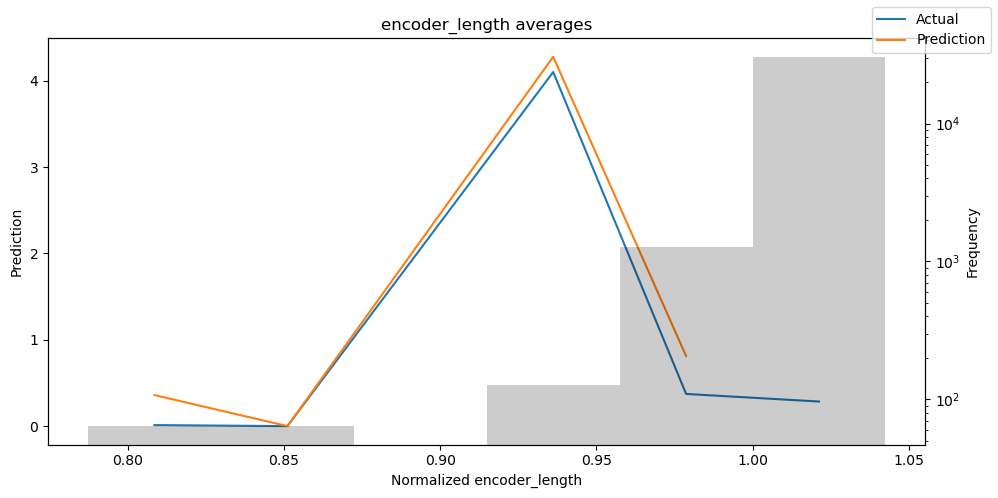

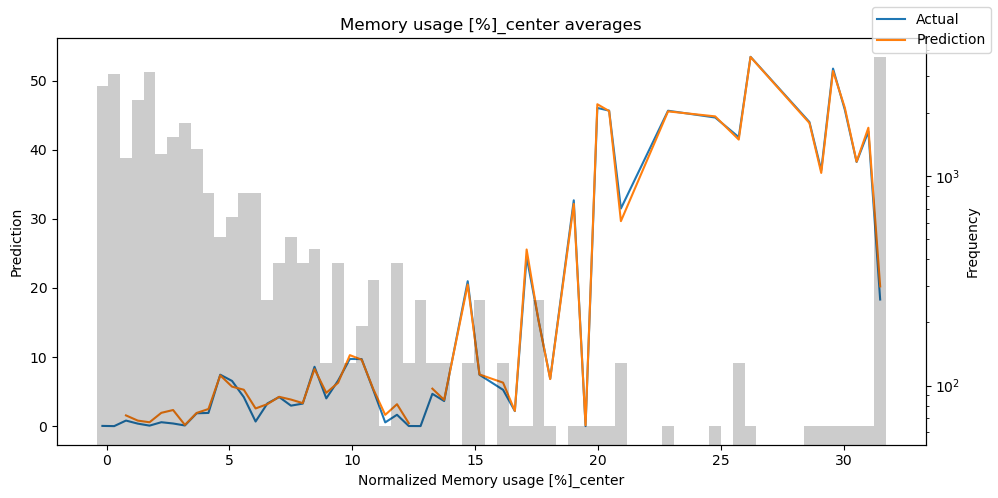

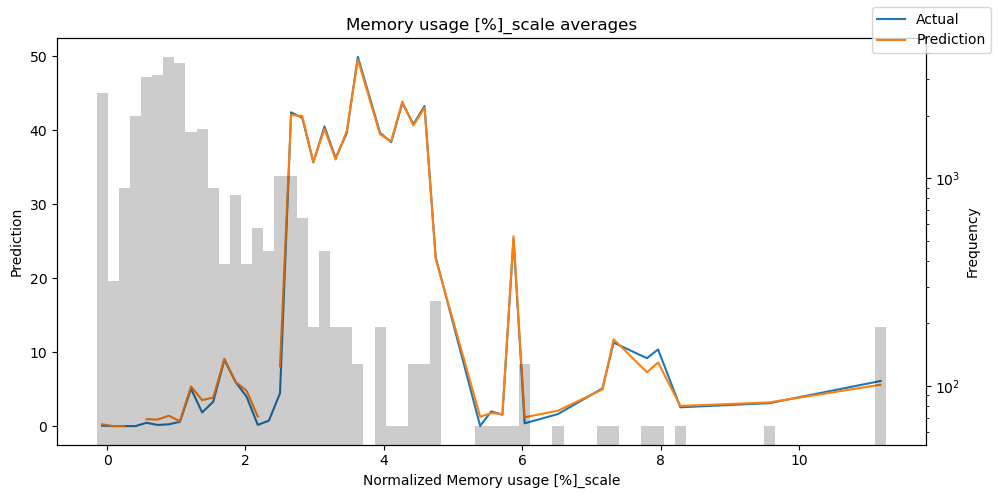

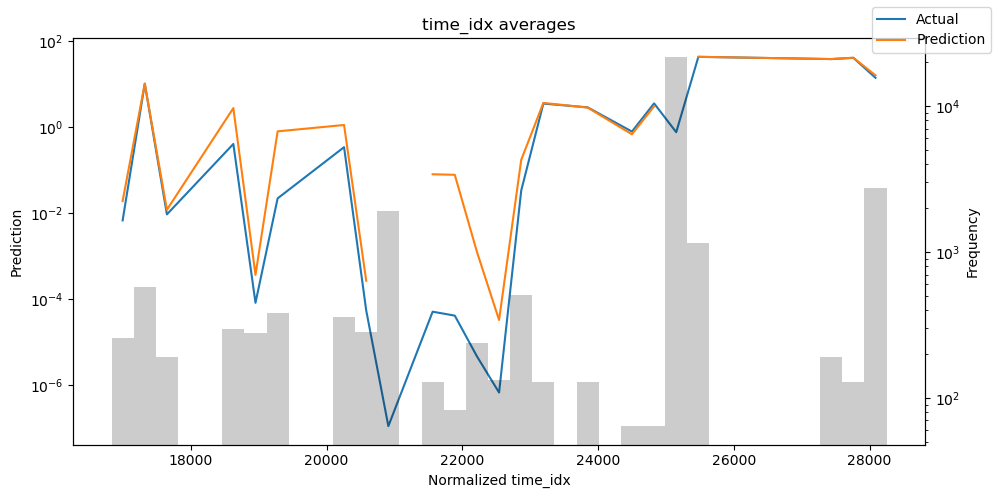

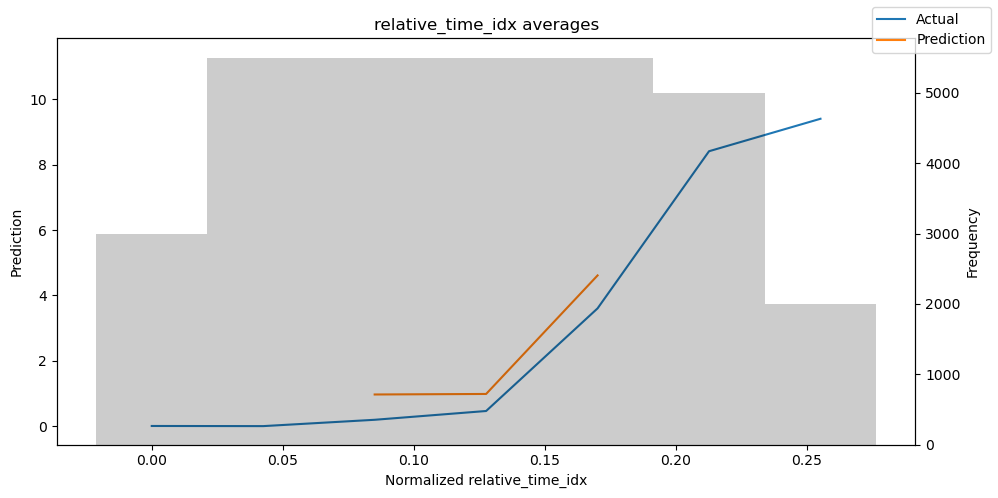

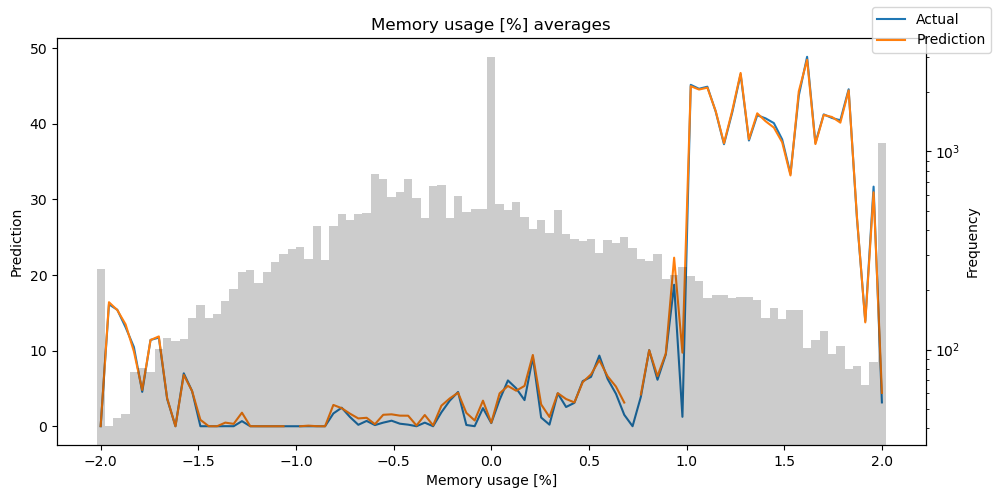

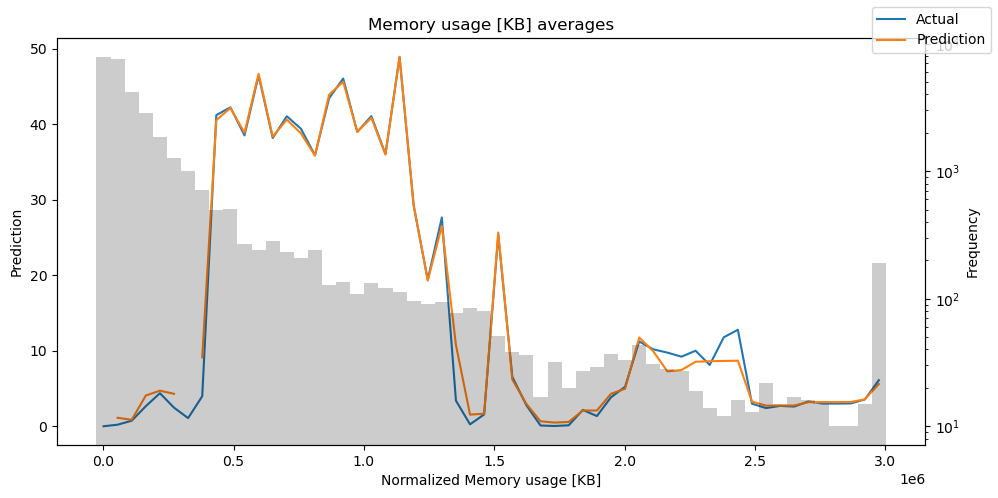

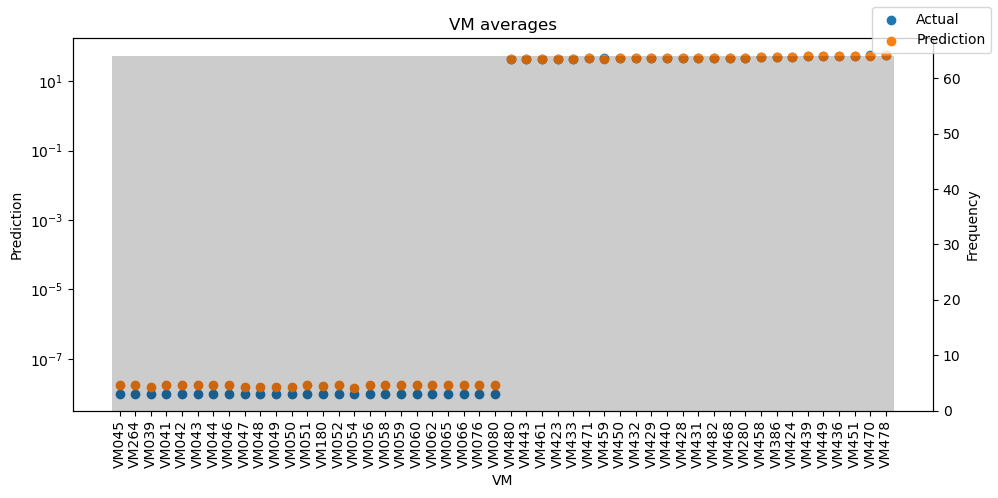

In [30]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

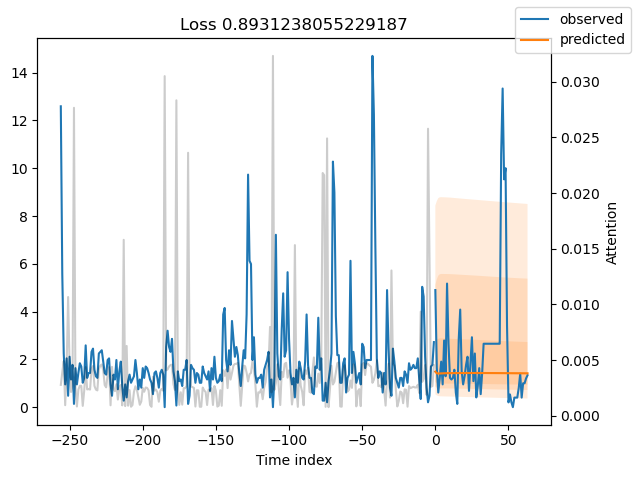

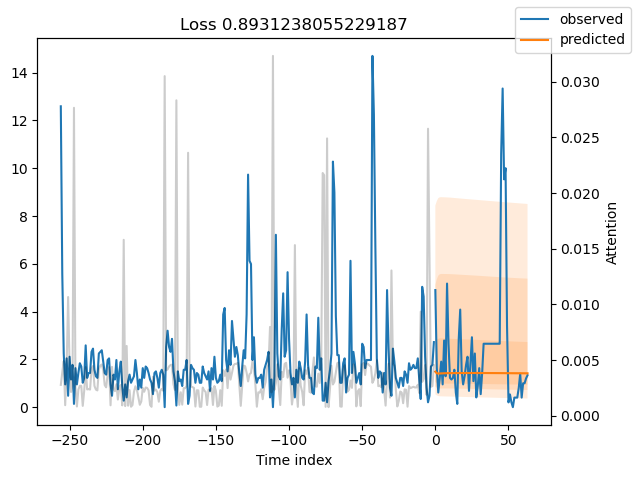

In [31]:
raw_prediction = best_tft.predict(
    training.filter(lambda x: (x["VM"] == "VM001")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, add_loss_to_title=True)